# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

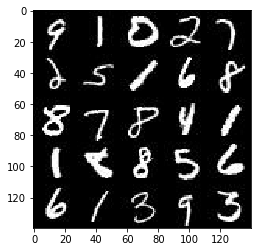

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

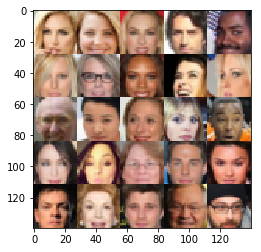

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', '

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
       
        
    alpha = 0.2
    keep_prob = 0.5
        
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)

        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
      #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same', kernel_initializer=kernel_initializer)
        #x3 = tf.layers.batch_normalization(x3, training = is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        #drop3 = tf.nn.dropout(x3, keep_prob=keep_prob)
    
    alpha = 0.2
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        drop2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        drop3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        
        return out
 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
        
    smooth = 0.1    
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)  * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)  * (1 - smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    iteration = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
            
                iteration += 1
             
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if iteration % 100 == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if iteration % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.9594... Generator Loss: 1.8577
Epoch 0/2... Discriminator Loss: 1.3109... Generator Loss: 1.2802
Epoch 0/2... Discriminator Loss: 1.2358... Generator Loss: 1.5735
Epoch 0/2... Discriminator Loss: 1.8448... Generator Loss: 1.1862
Epoch 0/2... Discriminator Loss: 1.5236... Generator Loss: 1.3962
Epoch 0/2... Discriminator Loss: 1.0971... Generator Loss: 1.7882
Epoch 0/2... Discriminator Loss: 1.0215... Generator Loss: 1.7591
Epoch 0/2... Discriminator Loss: 0.7963... Generator Loss: 1.9410
Epoch 0/2... Discriminator Loss: 0.8745... Generator Loss: 2.4230


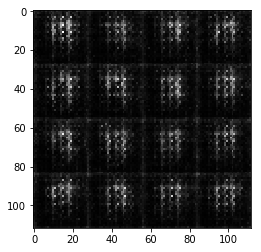

Epoch 0/2... Discriminator Loss: 0.9470... Generator Loss: 3.1695
Epoch 0/2... Discriminator Loss: 0.6756... Generator Loss: 2.3613
Epoch 0/2... Discriminator Loss: 1.0807... Generator Loss: 1.8408
Epoch 0/2... Discriminator Loss: 1.4884... Generator Loss: 1.7931
Epoch 0/2... Discriminator Loss: 0.9537... Generator Loss: 2.8323
Epoch 0/2... Discriminator Loss: 0.8185... Generator Loss: 2.7161
Epoch 0/2... Discriminator Loss: 1.9798... Generator Loss: 0.8276
Epoch 0/2... Discriminator Loss: 0.8295... Generator Loss: 3.2425
Epoch 0/2... Discriminator Loss: 0.8945... Generator Loss: 2.2536
Epoch 0/2... Discriminator Loss: 0.6358... Generator Loss: 2.7054


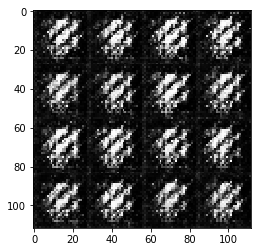

Epoch 0/2... Discriminator Loss: 1.1276... Generator Loss: 1.2774
Epoch 0/2... Discriminator Loss: 1.0860... Generator Loss: 2.1362
Epoch 0/2... Discriminator Loss: 0.7156... Generator Loss: 2.7877
Epoch 0/2... Discriminator Loss: 0.6993... Generator Loss: 2.5101
Epoch 0/2... Discriminator Loss: 0.7525... Generator Loss: 2.7696
Epoch 0/2... Discriminator Loss: 0.7844... Generator Loss: 2.5656
Epoch 0/2... Discriminator Loss: 0.9227... Generator Loss: 2.4429
Epoch 0/2... Discriminator Loss: 0.8051... Generator Loss: 2.6966
Epoch 0/2... Discriminator Loss: 0.7517... Generator Loss: 2.1158
Epoch 0/2... Discriminator Loss: 0.6183... Generator Loss: 2.5534


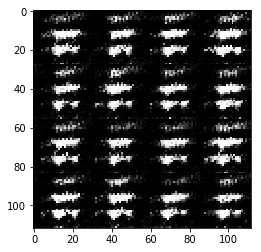

Epoch 0/2... Discriminator Loss: 0.6578... Generator Loss: 3.2045
Epoch 0/2... Discriminator Loss: 0.6487... Generator Loss: 2.4698
Epoch 0/2... Discriminator Loss: 1.2644... Generator Loss: 1.3729
Epoch 0/2... Discriminator Loss: 1.3866... Generator Loss: 0.9753
Epoch 0/2... Discriminator Loss: 0.9950... Generator Loss: 2.1336
Epoch 0/2... Discriminator Loss: 0.9669... Generator Loss: 1.8252
Epoch 0/2... Discriminator Loss: 1.1361... Generator Loss: 2.5832
Epoch 0/2... Discriminator Loss: 0.7695... Generator Loss: 2.3394
Epoch 0/2... Discriminator Loss: 0.9518... Generator Loss: 2.4888
Epoch 0/2... Discriminator Loss: 0.5254... Generator Loss: 3.6343


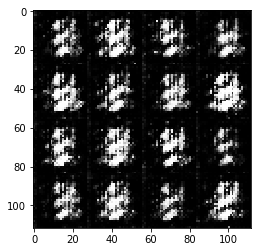

Epoch 0/2... Discriminator Loss: 0.8606... Generator Loss: 1.9784
Epoch 0/2... Discriminator Loss: 0.6604... Generator Loss: 3.1776
Epoch 0/2... Discriminator Loss: 0.7414... Generator Loss: 3.8281
Epoch 0/2... Discriminator Loss: 0.8246... Generator Loss: 2.2129
Epoch 0/2... Discriminator Loss: 0.8765... Generator Loss: 1.8477
Epoch 0/2... Discriminator Loss: 0.6998... Generator Loss: 2.4688
Epoch 0/2... Discriminator Loss: 0.8075... Generator Loss: 2.6630
Epoch 0/2... Discriminator Loss: 0.8030... Generator Loss: 3.1269
Epoch 0/2... Discriminator Loss: 0.5526... Generator Loss: 3.1695
Epoch 0/2... Discriminator Loss: 0.6540... Generator Loss: 3.4863


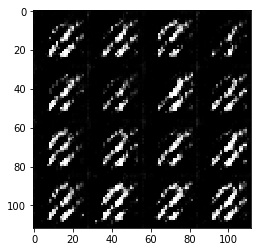

Epoch 0/2... Discriminator Loss: 0.7783... Generator Loss: 3.1179
Epoch 0/2... Discriminator Loss: 0.7948... Generator Loss: 2.8452
Epoch 0/2... Discriminator Loss: 0.7019... Generator Loss: 3.0004
Epoch 0/2... Discriminator Loss: 0.6495... Generator Loss: 2.7983
Epoch 0/2... Discriminator Loss: 0.5674... Generator Loss: 2.7037
Epoch 0/2... Discriminator Loss: 0.8110... Generator Loss: 2.8202
Epoch 0/2... Discriminator Loss: 0.7725... Generator Loss: 2.4156
Epoch 0/2... Discriminator Loss: 0.7247... Generator Loss: 3.3443
Epoch 0/2... Discriminator Loss: 0.6141... Generator Loss: 2.3832
Epoch 0/2... Discriminator Loss: 0.7274... Generator Loss: 3.1029


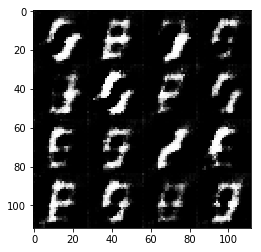

Epoch 0/2... Discriminator Loss: 0.9143... Generator Loss: 1.9459
Epoch 0/2... Discriminator Loss: 0.7755... Generator Loss: 1.9585
Epoch 0/2... Discriminator Loss: 0.8882... Generator Loss: 2.1901
Epoch 0/2... Discriminator Loss: 0.7311... Generator Loss: 2.2416
Epoch 0/2... Discriminator Loss: 0.6600... Generator Loss: 2.0360
Epoch 0/2... Discriminator Loss: 0.8175... Generator Loss: 2.7524
Epoch 0/2... Discriminator Loss: 0.7611... Generator Loss: 2.6089
Epoch 0/2... Discriminator Loss: 0.5947... Generator Loss: 2.7517
Epoch 0/2... Discriminator Loss: 0.8314... Generator Loss: 2.3096
Epoch 0/2... Discriminator Loss: 0.7287... Generator Loss: 1.9267


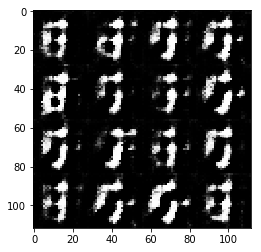

Epoch 0/2... Discriminator Loss: 0.6304... Generator Loss: 2.9202
Epoch 0/2... Discriminator Loss: 0.8433... Generator Loss: 3.2551
Epoch 0/2... Discriminator Loss: 0.6847... Generator Loss: 2.9529
Epoch 0/2... Discriminator Loss: 0.8118... Generator Loss: 2.4005
Epoch 0/2... Discriminator Loss: 0.6428... Generator Loss: 2.8218
Epoch 0/2... Discriminator Loss: 0.7819... Generator Loss: 2.7337
Epoch 0/2... Discriminator Loss: 0.7886... Generator Loss: 2.0527
Epoch 0/2... Discriminator Loss: 0.9656... Generator Loss: 1.7994
Epoch 0/2... Discriminator Loss: 0.7010... Generator Loss: 1.9741
Epoch 0/2... Discriminator Loss: 0.6544... Generator Loss: 2.5231


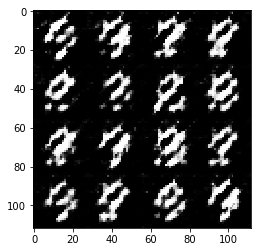

Epoch 0/2... Discriminator Loss: 0.6904... Generator Loss: 2.9562
Epoch 0/2... Discriminator Loss: 0.6952... Generator Loss: 2.8163
Epoch 0/2... Discriminator Loss: 0.6805... Generator Loss: 2.8420
Epoch 0/2... Discriminator Loss: 1.0443... Generator Loss: 1.9318
Epoch 0/2... Discriminator Loss: 0.5360... Generator Loss: 2.9639
Epoch 0/2... Discriminator Loss: 0.7621... Generator Loss: 2.2556
Epoch 0/2... Discriminator Loss: 0.7707... Generator Loss: 2.2862
Epoch 0/2... Discriminator Loss: 1.0974... Generator Loss: 1.3307
Epoch 0/2... Discriminator Loss: 1.0650... Generator Loss: 1.8840
Epoch 0/2... Discriminator Loss: 0.7900... Generator Loss: 2.3428


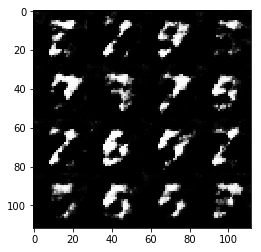

Epoch 0/2... Discriminator Loss: 0.5501... Generator Loss: 2.3937
Epoch 0/2... Discriminator Loss: 0.9271... Generator Loss: 2.6701
Epoch 0/2... Discriminator Loss: 0.7578... Generator Loss: 1.6177
Epoch 0/2... Discriminator Loss: 0.7464... Generator Loss: 2.1083
Epoch 0/2... Discriminator Loss: 0.6013... Generator Loss: 2.4571
Epoch 0/2... Discriminator Loss: 0.7342... Generator Loss: 2.1948
Epoch 0/2... Discriminator Loss: 0.5979... Generator Loss: 2.6005
Epoch 0/2... Discriminator Loss: 0.6699... Generator Loss: 2.4528
Epoch 0/2... Discriminator Loss: 1.0698... Generator Loss: 1.7184
Epoch 0/2... Discriminator Loss: 0.8386... Generator Loss: 2.4550


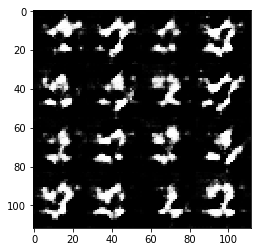

Epoch 0/2... Discriminator Loss: 0.6718... Generator Loss: 1.8101
Epoch 0/2... Discriminator Loss: 0.6189... Generator Loss: 2.0911
Epoch 0/2... Discriminator Loss: 0.8322... Generator Loss: 1.7645
Epoch 0/2... Discriminator Loss: 0.6102... Generator Loss: 2.0421
Epoch 0/2... Discriminator Loss: 0.8606... Generator Loss: 1.7992
Epoch 0/2... Discriminator Loss: 0.6975... Generator Loss: 1.9955
Epoch 0/2... Discriminator Loss: 0.8529... Generator Loss: 2.5865
Epoch 0/2... Discriminator Loss: 0.8645... Generator Loss: 1.7938
Epoch 0/2... Discriminator Loss: 0.7711... Generator Loss: 2.1547
Epoch 0/2... Discriminator Loss: 0.8550... Generator Loss: 2.3076


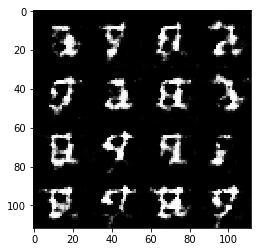

Epoch 0/2... Discriminator Loss: 1.0439... Generator Loss: 1.5456
Epoch 0/2... Discriminator Loss: 0.8773... Generator Loss: 2.3587
Epoch 0/2... Discriminator Loss: 0.9123... Generator Loss: 3.1432
Epoch 0/2... Discriminator Loss: 0.6655... Generator Loss: 2.6737
Epoch 0/2... Discriminator Loss: 0.8203... Generator Loss: 1.8938
Epoch 0/2... Discriminator Loss: 0.9720... Generator Loss: 1.8181
Epoch 0/2... Discriminator Loss: 0.9245... Generator Loss: 1.9767
Epoch 0/2... Discriminator Loss: 0.8047... Generator Loss: 2.3457
Epoch 0/2... Discriminator Loss: 0.7098... Generator Loss: 2.5245
Epoch 0/2... Discriminator Loss: 0.6076... Generator Loss: 2.5146


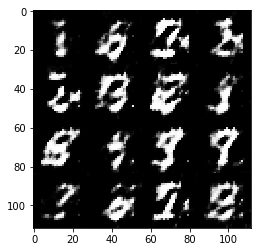

Epoch 0/2... Discriminator Loss: 0.9099... Generator Loss: 2.0822
Epoch 0/2... Discriminator Loss: 0.6608... Generator Loss: 2.1200
Epoch 0/2... Discriminator Loss: 0.5182... Generator Loss: 2.5893
Epoch 0/2... Discriminator Loss: 0.7976... Generator Loss: 1.6493
Epoch 0/2... Discriminator Loss: 0.7963... Generator Loss: 1.5349
Epoch 0/2... Discriminator Loss: 0.6403... Generator Loss: 2.1427
Epoch 0/2... Discriminator Loss: 0.9188... Generator Loss: 2.4927
Epoch 0/2... Discriminator Loss: 1.6251... Generator Loss: 0.7932
Epoch 0/2... Discriminator Loss: 0.8139... Generator Loss: 2.2105
Epoch 0/2... Discriminator Loss: 0.7678... Generator Loss: 2.0558


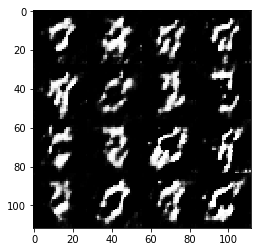

Epoch 0/2... Discriminator Loss: 1.0212... Generator Loss: 1.6036
Epoch 0/2... Discriminator Loss: 0.8453... Generator Loss: 2.1136
Epoch 0/2... Discriminator Loss: 1.1286... Generator Loss: 1.6329
Epoch 0/2... Discriminator Loss: 0.9584... Generator Loss: 2.1213
Epoch 0/2... Discriminator Loss: 0.9614... Generator Loss: 2.3070
Epoch 0/2... Discriminator Loss: 0.7675... Generator Loss: 1.8983
Epoch 0/2... Discriminator Loss: 1.0660... Generator Loss: 2.5803
Epoch 0/2... Discriminator Loss: 0.8116... Generator Loss: 2.2664
Epoch 0/2... Discriminator Loss: 0.8713... Generator Loss: 1.9802
Epoch 0/2... Discriminator Loss: 0.8781... Generator Loss: 1.5303


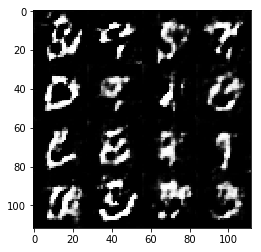

Epoch 0/2... Discriminator Loss: 0.6674... Generator Loss: 2.2499
Epoch 0/2... Discriminator Loss: 0.9617... Generator Loss: 1.7886
Epoch 0/2... Discriminator Loss: 0.8880... Generator Loss: 1.9057
Epoch 0/2... Discriminator Loss: 0.9670... Generator Loss: 2.2847
Epoch 0/2... Discriminator Loss: 0.9064... Generator Loss: 2.0740
Epoch 0/2... Discriminator Loss: 0.9364... Generator Loss: 1.4038
Epoch 0/2... Discriminator Loss: 1.1421... Generator Loss: 1.9245
Epoch 0/2... Discriminator Loss: 0.8826... Generator Loss: 1.2447
Epoch 0/2... Discriminator Loss: 0.7701... Generator Loss: 2.0142
Epoch 0/2... Discriminator Loss: 0.9346... Generator Loss: 1.9815


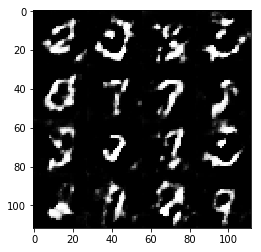

Epoch 0/2... Discriminator Loss: 1.0074... Generator Loss: 2.5821
Epoch 0/2... Discriminator Loss: 0.8264... Generator Loss: 1.1982
Epoch 0/2... Discriminator Loss: 1.0325... Generator Loss: 1.4735
Epoch 0/2... Discriminator Loss: 0.6873... Generator Loss: 1.7168
Epoch 0/2... Discriminator Loss: 0.7183... Generator Loss: 2.0670
Epoch 0/2... Discriminator Loss: 0.9604... Generator Loss: 1.7207
Epoch 0/2... Discriminator Loss: 0.9651... Generator Loss: 1.6970
Epoch 0/2... Discriminator Loss: 0.9212... Generator Loss: 1.9648
Epoch 0/2... Discriminator Loss: 1.0408... Generator Loss: 1.8972
Epoch 0/2... Discriminator Loss: 0.9297... Generator Loss: 1.9943


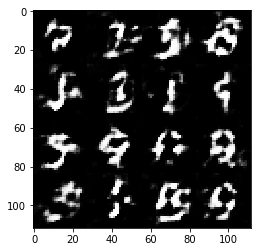

Epoch 0/2... Discriminator Loss: 1.3832... Generator Loss: 1.0578
Epoch 0/2... Discriminator Loss: 0.9327... Generator Loss: 2.2923
Epoch 0/2... Discriminator Loss: 0.6877... Generator Loss: 1.9731
Epoch 0/2... Discriminator Loss: 1.0786... Generator Loss: 1.6239
Epoch 0/2... Discriminator Loss: 0.7597... Generator Loss: 1.8217
Epoch 0/2... Discriminator Loss: 0.6810... Generator Loss: 2.1569
Epoch 0/2... Discriminator Loss: 1.0024... Generator Loss: 1.2293
Epoch 0/2... Discriminator Loss: 1.1835... Generator Loss: 1.8014
Epoch 0/2... Discriminator Loss: 1.0942... Generator Loss: 1.7416
Epoch 0/2... Discriminator Loss: 1.1625... Generator Loss: 1.4904


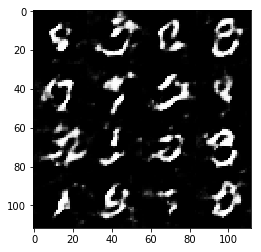

Epoch 0/2... Discriminator Loss: 0.6784... Generator Loss: 2.3486
Epoch 0/2... Discriminator Loss: 0.7447... Generator Loss: 1.4651
Epoch 0/2... Discriminator Loss: 1.1723... Generator Loss: 0.9214
Epoch 0/2... Discriminator Loss: 0.8347... Generator Loss: 1.6089
Epoch 0/2... Discriminator Loss: 0.9350... Generator Loss: 1.4359
Epoch 0/2... Discriminator Loss: 1.0672... Generator Loss: 1.5474
Epoch 0/2... Discriminator Loss: 0.7257... Generator Loss: 1.7233
Epoch 0/2... Discriminator Loss: 0.8588... Generator Loss: 1.5007
Epoch 0/2... Discriminator Loss: 0.9446... Generator Loss: 1.8712
Epoch 0/2... Discriminator Loss: 1.0439... Generator Loss: 1.2696


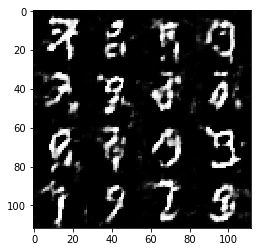

Epoch 0/2... Discriminator Loss: 0.9212... Generator Loss: 2.0647
Epoch 0/2... Discriminator Loss: 1.3267... Generator Loss: 0.9558
Epoch 0/2... Discriminator Loss: 1.1288... Generator Loss: 1.7682
Epoch 0/2... Discriminator Loss: 0.9792... Generator Loss: 1.3103
Epoch 0/2... Discriminator Loss: 1.0134... Generator Loss: 1.5938
Epoch 0/2... Discriminator Loss: 0.9272... Generator Loss: 2.2987
Epoch 0/2... Discriminator Loss: 0.8392... Generator Loss: 1.5935
Epoch 0/2... Discriminator Loss: 0.9741... Generator Loss: 2.2354
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.8373
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 1.4825


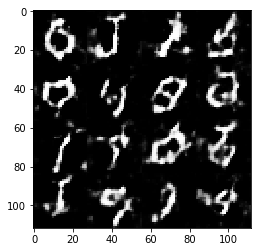

Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.7057
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 2.1547
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 1.3937
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.5558
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.6766
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 1.4512


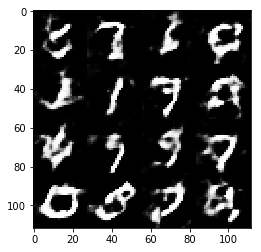

Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.6314
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.9295
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.8864
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 2.1414
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.7544
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 1.7151
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.2270


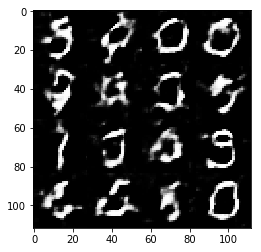

Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.3280
Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 1.8874
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 1.3204
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 1.5808


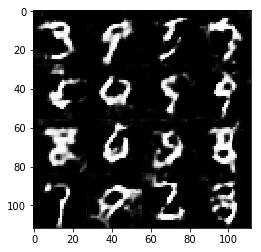

Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 1.3127
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.4137
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 1.8710
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.2805
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 2.0442
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 2.0878
Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 1.9992


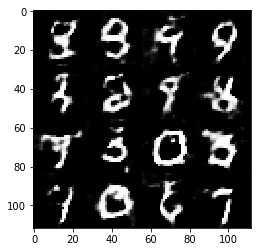

Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.6231
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.8112
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 2.2498
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.3025
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.6737
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.8285
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.7901
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.4243
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 2.0485


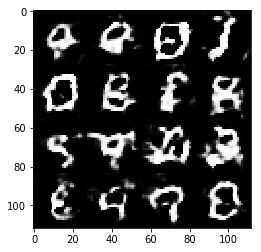

Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.4624
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 2.7092
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.6970
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 2.3287
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.4633
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 1.3855
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.6977
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 2.2041


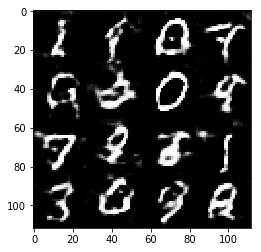

Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.1980
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 1.4564
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.6680
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 2.2527
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 2.4796
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 2.5089
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 2.4743


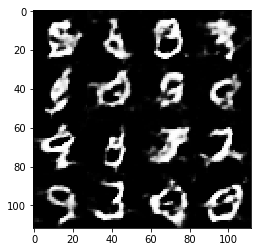

Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.5404
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 2.2005
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.6371
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 1.8278
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.6298
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 1.6145
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.5421
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.6340
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 1.4323


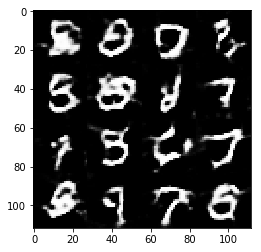

Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 1.7259
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 2.1177
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.9543
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 1.8983
Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.8066
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.8814
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.7413


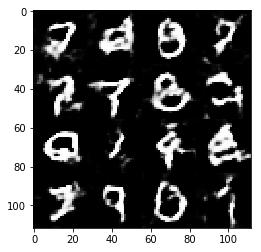

Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 1.3625
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 2.1928
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 2.3192
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.9672
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 2.7371
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 1.6581
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 2.3735
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 2.2472


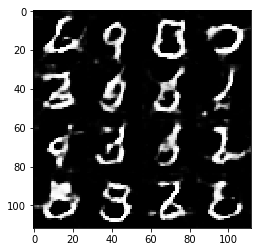

Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.6549
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.6645
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 1.9628
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 2.2093
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 2.3358
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 1.2748


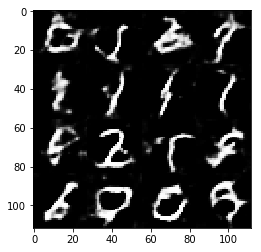

Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.7251
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.7434
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.5449
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 1.2924
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.9996
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 2.0118
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.4353
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 2.8965


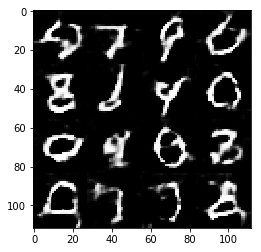

Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 2.0117
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 2.5489
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.4124
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 2.0774
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.5324
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.3008
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.6557


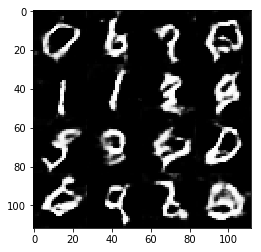

Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.7936
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 2.1741
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 2.2744
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.7667
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.2396
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.6978
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 2.7233
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 2.0355
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.1427


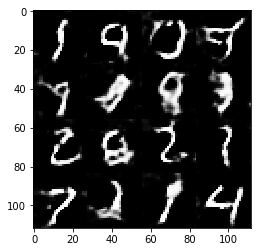

Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 2.0124
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 2.5795
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 2.4350
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.9702
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.2473
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 2.1907
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.3958


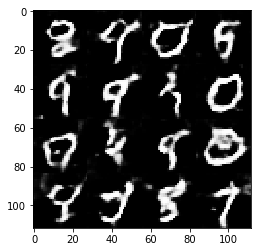

Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.0451
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 1.5711
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.6265
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 1.3020


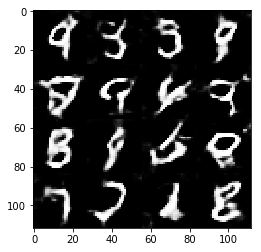

Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.9222
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.7586
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.9707
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.9021
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 2.4877
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.9463
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 1.8473


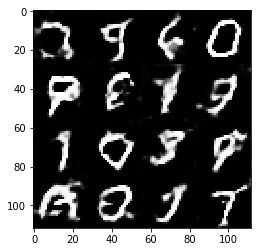

Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.4591
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 2.2134
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.5482
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 1.4648
Epoch 1/2... Discriminator Loss: 0.5591... Generator Loss: 2.3899
Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 1.9760
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.0268
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 1.9581


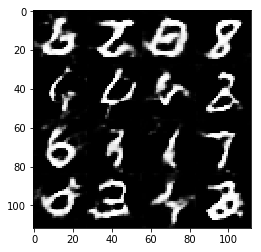

Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 1.6913
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.5620
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 1.5363
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.4908


In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.8324... Generator Loss: 3.2361
Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 3.8595
Epoch 0/1... Discriminator Loss: 0.7868... Generator Loss: 2.5583
Epoch 0/1... Discriminator Loss: 0.7138... Generator Loss: 4.1686
Epoch 0/1... Discriminator Loss: 0.8145... Generator Loss: 2.2939
Epoch 0/1... Discriminator Loss: 0.7934... Generator Loss: 2.7989
Epoch 0/1... Discriminator Loss: 0.6432... Generator Loss: 6.2344
Epoch 0/1... Discriminator Loss: 0.6219... Generator Loss: 3.7246
Epoch 0/1... Discriminator Loss: 0.6012... Generator Loss: 3.5858


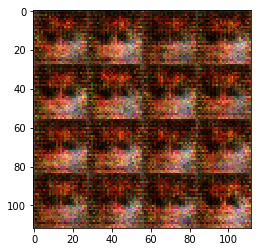

Epoch 0/1... Discriminator Loss: 0.4741... Generator Loss: 4.6833
Epoch 0/1... Discriminator Loss: 0.4784... Generator Loss: 3.7341
Epoch 0/1... Discriminator Loss: 0.5304... Generator Loss: 3.4391
Epoch 0/1... Discriminator Loss: 0.4897... Generator Loss: 3.1739
Epoch 0/1... Discriminator Loss: 0.5036... Generator Loss: 4.0682
Epoch 0/1... Discriminator Loss: 0.4652... Generator Loss: 3.7526
Epoch 0/1... Discriminator Loss: 0.4506... Generator Loss: 3.6926
Epoch 0/1... Discriminator Loss: 0.5597... Generator Loss: 2.6069
Epoch 0/1... Discriminator Loss: 0.4572... Generator Loss: 4.1778
Epoch 0/1... Discriminator Loss: 0.5437... Generator Loss: 7.0283


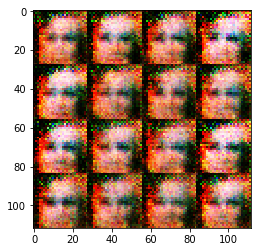

Epoch 0/1... Discriminator Loss: 0.4368... Generator Loss: 3.7154
Epoch 0/1... Discriminator Loss: 0.8011... Generator Loss: 1.7574
Epoch 0/1... Discriminator Loss: 0.5311... Generator Loss: 3.2561
Epoch 0/1... Discriminator Loss: 1.4934... Generator Loss: 0.9529
Epoch 0/1... Discriminator Loss: 3.4497... Generator Loss: 9.5038
Epoch 0/1... Discriminator Loss: 0.5263... Generator Loss: 3.5341
Epoch 0/1... Discriminator Loss: 0.6348... Generator Loss: 2.9786
Epoch 0/1... Discriminator Loss: 0.5951... Generator Loss: 2.1943
Epoch 0/1... Discriminator Loss: 0.5105... Generator Loss: 2.7395
Epoch 0/1... Discriminator Loss: 0.6595... Generator Loss: 2.0376


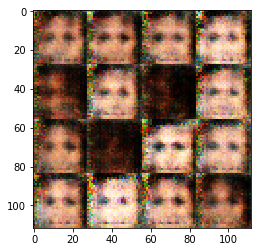

Epoch 0/1... Discriminator Loss: 0.7672... Generator Loss: 1.6248
Epoch 0/1... Discriminator Loss: 0.6862... Generator Loss: 1.7869
Epoch 0/1... Discriminator Loss: 1.1609... Generator Loss: 0.9533
Epoch 0/1... Discriminator Loss: 0.9670... Generator Loss: 1.2472
Epoch 0/1... Discriminator Loss: 0.7041... Generator Loss: 2.4663
Epoch 0/1... Discriminator Loss: 0.5821... Generator Loss: 2.2015
Epoch 0/1... Discriminator Loss: 0.4391... Generator Loss: 3.9439
Epoch 0/1... Discriminator Loss: 1.0153... Generator Loss: 1.4939
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 4.1684
Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.7960


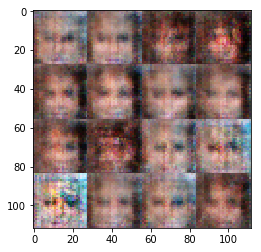

Epoch 0/1... Discriminator Loss: 1.1488... Generator Loss: 1.3311
Epoch 0/1... Discriminator Loss: 0.8295... Generator Loss: 1.7830
Epoch 0/1... Discriminator Loss: 0.7781... Generator Loss: 1.6911
Epoch 0/1... Discriminator Loss: 1.1074... Generator Loss: 1.4804
Epoch 0/1... Discriminator Loss: 0.8123... Generator Loss: 2.0802
Epoch 0/1... Discriminator Loss: 0.9818... Generator Loss: 1.5345
Epoch 0/1... Discriminator Loss: 0.9971... Generator Loss: 1.5037
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 1.7847
Epoch 0/1... Discriminator Loss: 1.0001... Generator Loss: 1.4895
Epoch 0/1... Discriminator Loss: 0.8293... Generator Loss: 1.6872


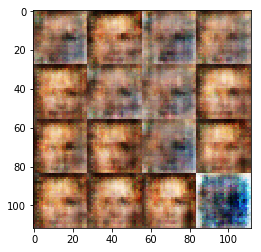

Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.7530
Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 1.8846
Epoch 0/1... Discriminator Loss: 1.2446... Generator Loss: 0.9466
Epoch 0/1... Discriminator Loss: 0.9392... Generator Loss: 1.6757
Epoch 0/1... Discriminator Loss: 0.9732... Generator Loss: 1.6034
Epoch 0/1... Discriminator Loss: 1.1233... Generator Loss: 1.3059
Epoch 0/1... Discriminator Loss: 0.8689... Generator Loss: 1.6238
Epoch 0/1... Discriminator Loss: 0.9412... Generator Loss: 1.5669
Epoch 0/1... Discriminator Loss: 0.9482... Generator Loss: 1.5351
Epoch 0/1... Discriminator Loss: 1.3969... Generator Loss: 0.9508


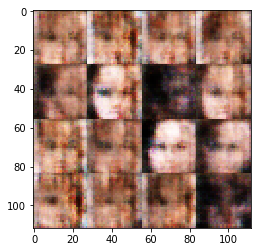

Epoch 0/1... Discriminator Loss: 1.0644... Generator Loss: 1.5421
Epoch 0/1... Discriminator Loss: 1.0549... Generator Loss: 1.2478
Epoch 0/1... Discriminator Loss: 1.1196... Generator Loss: 2.1932
Epoch 0/1... Discriminator Loss: 1.0665... Generator Loss: 1.3086
Epoch 0/1... Discriminator Loss: 1.2322... Generator Loss: 1.0980
Epoch 0/1... Discriminator Loss: 0.9283... Generator Loss: 1.5760
Epoch 0/1... Discriminator Loss: 1.1117... Generator Loss: 1.3428
Epoch 0/1... Discriminator Loss: 0.6672... Generator Loss: 2.2103
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.7162
Epoch 0/1... Discriminator Loss: 0.9895... Generator Loss: 1.7275


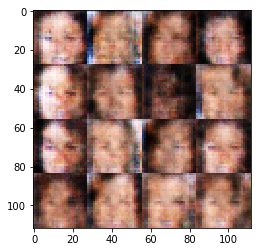

Epoch 0/1... Discriminator Loss: 1.0045... Generator Loss: 1.8709
Epoch 0/1... Discriminator Loss: 1.1476... Generator Loss: 3.5581
Epoch 0/1... Discriminator Loss: 1.1510... Generator Loss: 1.3715
Epoch 0/1... Discriminator Loss: 0.7949... Generator Loss: 1.6008
Epoch 0/1... Discriminator Loss: 0.9971... Generator Loss: 1.2304
Epoch 0/1... Discriminator Loss: 0.9145... Generator Loss: 1.5451
Epoch 0/1... Discriminator Loss: 0.9019... Generator Loss: 1.7622
Epoch 0/1... Discriminator Loss: 0.9709... Generator Loss: 1.7498
Epoch 0/1... Discriminator Loss: 0.8955... Generator Loss: 1.6043
Epoch 0/1... Discriminator Loss: 0.8770... Generator Loss: 1.9973


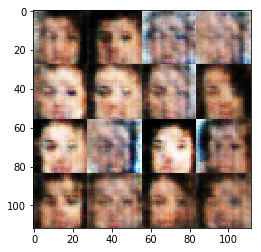

Epoch 0/1... Discriminator Loss: 0.7589... Generator Loss: 1.7063
Epoch 0/1... Discriminator Loss: 1.0498... Generator Loss: 2.5880
Epoch 0/1... Discriminator Loss: 0.7365... Generator Loss: 2.0488
Epoch 0/1... Discriminator Loss: 0.9728... Generator Loss: 1.5844
Epoch 0/1... Discriminator Loss: 0.7557... Generator Loss: 1.8093
Epoch 0/1... Discriminator Loss: 1.2541... Generator Loss: 1.0576
Epoch 0/1... Discriminator Loss: 0.8783... Generator Loss: 1.9842
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 1.2844
Epoch 0/1... Discriminator Loss: 0.9494... Generator Loss: 2.0946
Epoch 0/1... Discriminator Loss: 0.9669... Generator Loss: 1.7264


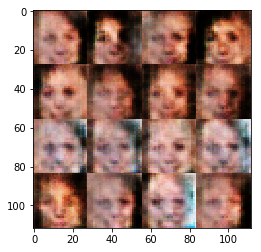

Epoch 0/1... Discriminator Loss: 0.8300... Generator Loss: 2.2702
Epoch 0/1... Discriminator Loss: 0.8760... Generator Loss: 1.5407
Epoch 0/1... Discriminator Loss: 0.8369... Generator Loss: 2.1156
Epoch 0/1... Discriminator Loss: 0.9414... Generator Loss: 1.5017
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.6351
Epoch 0/1... Discriminator Loss: 0.8459... Generator Loss: 1.5007
Epoch 0/1... Discriminator Loss: 0.9271... Generator Loss: 1.5979
Epoch 0/1... Discriminator Loss: 1.0915... Generator Loss: 1.0746
Epoch 0/1... Discriminator Loss: 0.8495... Generator Loss: 1.4298
Epoch 0/1... Discriminator Loss: 1.0515... Generator Loss: 1.7562


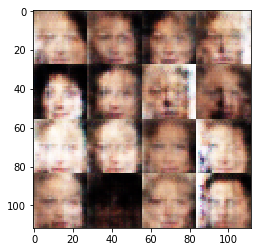

Epoch 0/1... Discriminator Loss: 0.9293... Generator Loss: 1.6183
Epoch 0/1... Discriminator Loss: 0.9317... Generator Loss: 1.7781
Epoch 0/1... Discriminator Loss: 0.9214... Generator Loss: 1.6528
Epoch 0/1... Discriminator Loss: 1.1043... Generator Loss: 2.4607
Epoch 0/1... Discriminator Loss: 0.8331... Generator Loss: 1.5832
Epoch 0/1... Discriminator Loss: 0.9042... Generator Loss: 1.7630
Epoch 0/1... Discriminator Loss: 0.8588... Generator Loss: 1.8389
Epoch 0/1... Discriminator Loss: 0.8277... Generator Loss: 1.9414
Epoch 0/1... Discriminator Loss: 0.9224... Generator Loss: 1.8411
Epoch 0/1... Discriminator Loss: 1.0875... Generator Loss: 1.1559


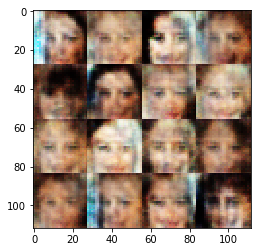

Epoch 0/1... Discriminator Loss: 0.9476... Generator Loss: 1.7188
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 1.5714
Epoch 0/1... Discriminator Loss: 1.0167... Generator Loss: 1.4732
Epoch 0/1... Discriminator Loss: 0.9482... Generator Loss: 1.6845
Epoch 0/1... Discriminator Loss: 0.8189... Generator Loss: 1.7637
Epoch 0/1... Discriminator Loss: 0.9568... Generator Loss: 1.3520
Epoch 0/1... Discriminator Loss: 1.1346... Generator Loss: 1.7281
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 1.2987
Epoch 0/1... Discriminator Loss: 0.9427... Generator Loss: 1.4558
Epoch 0/1... Discriminator Loss: 1.0451... Generator Loss: 1.7336


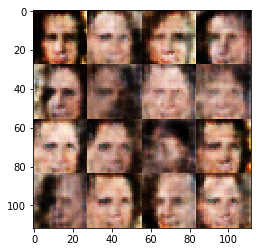

Epoch 0/1... Discriminator Loss: 0.8552... Generator Loss: 1.4417
Epoch 0/1... Discriminator Loss: 0.9437... Generator Loss: 1.7374
Epoch 0/1... Discriminator Loss: 1.2965... Generator Loss: 1.0322
Epoch 0/1... Discriminator Loss: 1.0148... Generator Loss: 1.5899
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 1.4961
Epoch 0/1... Discriminator Loss: 0.9937... Generator Loss: 1.2796
Epoch 0/1... Discriminator Loss: 1.1229... Generator Loss: 1.6602
Epoch 0/1... Discriminator Loss: 0.9501... Generator Loss: 1.3996
Epoch 0/1... Discriminator Loss: 0.8899... Generator Loss: 1.4255
Epoch 0/1... Discriminator Loss: 0.8416... Generator Loss: 1.3713


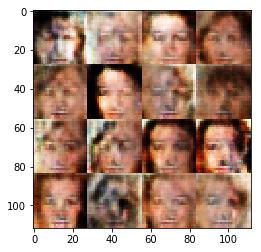

Epoch 0/1... Discriminator Loss: 1.5101... Generator Loss: 0.8548
Epoch 0/1... Discriminator Loss: 1.0046... Generator Loss: 1.4033
Epoch 0/1... Discriminator Loss: 0.9458... Generator Loss: 1.5926
Epoch 0/1... Discriminator Loss: 0.8676... Generator Loss: 1.6030
Epoch 0/1... Discriminator Loss: 0.9937... Generator Loss: 1.6986
Epoch 0/1... Discriminator Loss: 1.0550... Generator Loss: 1.2651
Epoch 0/1... Discriminator Loss: 1.1029... Generator Loss: 1.9840
Epoch 0/1... Discriminator Loss: 1.1483... Generator Loss: 1.1625
Epoch 0/1... Discriminator Loss: 1.1226... Generator Loss: 1.5570
Epoch 0/1... Discriminator Loss: 1.1219... Generator Loss: 1.1773


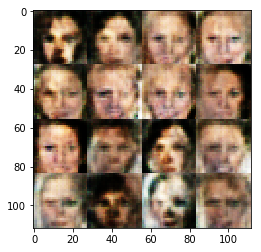

Epoch 0/1... Discriminator Loss: 1.0059... Generator Loss: 1.5031
Epoch 0/1... Discriminator Loss: 1.0844... Generator Loss: 1.4221
Epoch 0/1... Discriminator Loss: 0.9432... Generator Loss: 1.3890
Epoch 0/1... Discriminator Loss: 1.0017... Generator Loss: 1.9064
Epoch 0/1... Discriminator Loss: 0.9959... Generator Loss: 1.4532
Epoch 0/1... Discriminator Loss: 1.0461... Generator Loss: 1.4320
Epoch 0/1... Discriminator Loss: 1.1260... Generator Loss: 1.5618
Epoch 0/1... Discriminator Loss: 0.8341... Generator Loss: 1.6213
Epoch 0/1... Discriminator Loss: 1.4146... Generator Loss: 0.9011
Epoch 0/1... Discriminator Loss: 0.8411... Generator Loss: 2.0856


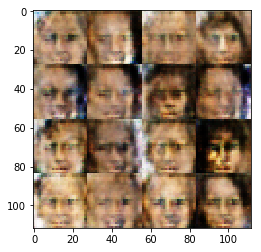

Epoch 0/1... Discriminator Loss: 0.9150... Generator Loss: 1.6440
Epoch 0/1... Discriminator Loss: 1.3022... Generator Loss: 0.8881
Epoch 0/1... Discriminator Loss: 0.8959... Generator Loss: 1.8361
Epoch 0/1... Discriminator Loss: 1.0234... Generator Loss: 1.2537
Epoch 0/1... Discriminator Loss: 1.1929... Generator Loss: 1.0653
Epoch 0/1... Discriminator Loss: 0.9563... Generator Loss: 1.5407
Epoch 0/1... Discriminator Loss: 1.1412... Generator Loss: 1.4181
Epoch 0/1... Discriminator Loss: 0.8841... Generator Loss: 1.7870
Epoch 0/1... Discriminator Loss: 0.9417... Generator Loss: 1.6865
Epoch 0/1... Discriminator Loss: 1.0383... Generator Loss: 1.2905


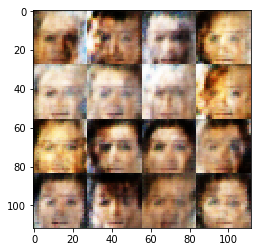

Epoch 0/1... Discriminator Loss: 1.0180... Generator Loss: 1.1636
Epoch 0/1... Discriminator Loss: 1.0387... Generator Loss: 1.7336
Epoch 0/1... Discriminator Loss: 1.1255... Generator Loss: 1.0443
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 1.2943
Epoch 0/1... Discriminator Loss: 1.1712... Generator Loss: 1.5856
Epoch 0/1... Discriminator Loss: 0.8361... Generator Loss: 1.5985
Epoch 0/1... Discriminator Loss: 1.0489... Generator Loss: 1.7329
Epoch 0/1... Discriminator Loss: 0.9091... Generator Loss: 1.4729
Epoch 0/1... Discriminator Loss: 1.0838... Generator Loss: 1.0459
Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.5105


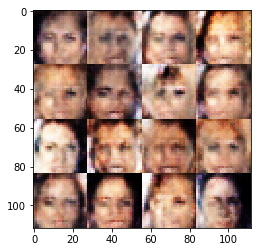

Epoch 0/1... Discriminator Loss: 1.1432... Generator Loss: 2.0990
Epoch 0/1... Discriminator Loss: 1.0819... Generator Loss: 1.5347
Epoch 0/1... Discriminator Loss: 1.0955... Generator Loss: 1.8010
Epoch 0/1... Discriminator Loss: 0.9380... Generator Loss: 1.3220
Epoch 0/1... Discriminator Loss: 1.1336... Generator Loss: 1.0928
Epoch 0/1... Discriminator Loss: 1.2533... Generator Loss: 1.0387
Epoch 0/1... Discriminator Loss: 1.0778... Generator Loss: 1.3028
Epoch 0/1... Discriminator Loss: 1.2325... Generator Loss: 1.8313
Epoch 0/1... Discriminator Loss: 0.8900... Generator Loss: 1.4834
Epoch 0/1... Discriminator Loss: 0.8089... Generator Loss: 1.9323


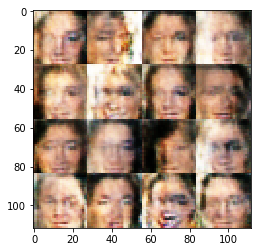

Epoch 0/1... Discriminator Loss: 0.9314... Generator Loss: 1.1701
Epoch 0/1... Discriminator Loss: 1.2328... Generator Loss: 0.9729
Epoch 0/1... Discriminator Loss: 0.9895... Generator Loss: 1.4369
Epoch 0/1... Discriminator Loss: 0.9957... Generator Loss: 1.4986
Epoch 0/1... Discriminator Loss: 1.1208... Generator Loss: 1.3297
Epoch 0/1... Discriminator Loss: 1.0715... Generator Loss: 1.7131
Epoch 0/1... Discriminator Loss: 1.0091... Generator Loss: 1.1831
Epoch 0/1... Discriminator Loss: 1.3066... Generator Loss: 1.5386
Epoch 0/1... Discriminator Loss: 1.0579... Generator Loss: 1.1621
Epoch 0/1... Discriminator Loss: 0.9765... Generator Loss: 1.7874


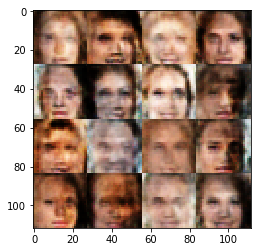

Epoch 0/1... Discriminator Loss: 1.0097... Generator Loss: 1.5173
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.5554
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 1.1285
Epoch 0/1... Discriminator Loss: 0.9214... Generator Loss: 1.6241
Epoch 0/1... Discriminator Loss: 1.0969... Generator Loss: 1.3143
Epoch 0/1... Discriminator Loss: 1.2033... Generator Loss: 1.5364
Epoch 0/1... Discriminator Loss: 1.0484... Generator Loss: 1.4155
Epoch 0/1... Discriminator Loss: 1.0280... Generator Loss: 1.3538
Epoch 0/1... Discriminator Loss: 1.0437... Generator Loss: 1.4561
Epoch 0/1... Discriminator Loss: 1.0191... Generator Loss: 1.1620


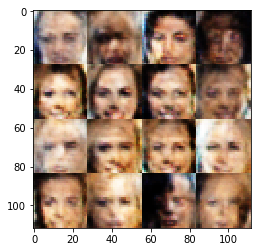

Epoch 0/1... Discriminator Loss: 0.8956... Generator Loss: 1.3959
Epoch 0/1... Discriminator Loss: 1.0489... Generator Loss: 1.2566
Epoch 0/1... Discriminator Loss: 1.0943... Generator Loss: 1.6307
Epoch 0/1... Discriminator Loss: 1.0842... Generator Loss: 1.4202
Epoch 0/1... Discriminator Loss: 1.1073... Generator Loss: 1.2081
Epoch 0/1... Discriminator Loss: 1.4770... Generator Loss: 0.7168
Epoch 0/1... Discriminator Loss: 0.9520... Generator Loss: 1.5522
Epoch 0/1... Discriminator Loss: 1.0034... Generator Loss: 1.3325
Epoch 0/1... Discriminator Loss: 1.0794... Generator Loss: 1.5848
Epoch 0/1... Discriminator Loss: 1.1002... Generator Loss: 1.1629


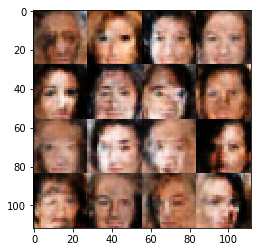

Epoch 0/1... Discriminator Loss: 0.9946... Generator Loss: 1.5651
Epoch 0/1... Discriminator Loss: 0.9919... Generator Loss: 1.6750
Epoch 0/1... Discriminator Loss: 1.1158... Generator Loss: 1.2602
Epoch 0/1... Discriminator Loss: 0.9751... Generator Loss: 1.2400
Epoch 0/1... Discriminator Loss: 1.1832... Generator Loss: 1.2733
Epoch 0/1... Discriminator Loss: 0.9190... Generator Loss: 1.9727
Epoch 0/1... Discriminator Loss: 1.3643... Generator Loss: 1.1593
Epoch 0/1... Discriminator Loss: 0.9621... Generator Loss: 1.7959
Epoch 0/1... Discriminator Loss: 0.8639... Generator Loss: 1.6101
Epoch 0/1... Discriminator Loss: 1.0265... Generator Loss: 1.1496


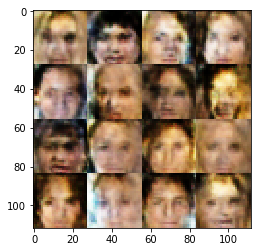

Epoch 0/1... Discriminator Loss: 1.0478... Generator Loss: 1.4100
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 1.0596
Epoch 0/1... Discriminator Loss: 1.1794... Generator Loss: 1.6830
Epoch 0/1... Discriminator Loss: 1.1912... Generator Loss: 1.0254
Epoch 0/1... Discriminator Loss: 1.1991... Generator Loss: 1.4058
Epoch 0/1... Discriminator Loss: 1.1079... Generator Loss: 1.0331
Epoch 0/1... Discriminator Loss: 0.8936... Generator Loss: 1.6231
Epoch 0/1... Discriminator Loss: 1.2144... Generator Loss: 1.5603
Epoch 0/1... Discriminator Loss: 1.2008... Generator Loss: 0.9150
Epoch 0/1... Discriminator Loss: 1.0018... Generator Loss: 1.5689


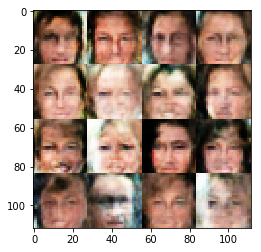

Epoch 0/1... Discriminator Loss: 1.3649... Generator Loss: 1.2368
Epoch 0/1... Discriminator Loss: 1.0330... Generator Loss: 0.9953
Epoch 0/1... Discriminator Loss: 1.0758... Generator Loss: 1.2548
Epoch 0/1... Discriminator Loss: 1.0194... Generator Loss: 1.4136
Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 1.2072
Epoch 0/1... Discriminator Loss: 1.0303... Generator Loss: 1.2857
Epoch 0/1... Discriminator Loss: 1.0164... Generator Loss: 1.5323
Epoch 0/1... Discriminator Loss: 0.9812... Generator Loss: 1.4832
Epoch 0/1... Discriminator Loss: 1.0839... Generator Loss: 1.1579
Epoch 0/1... Discriminator Loss: 1.1078... Generator Loss: 0.9756


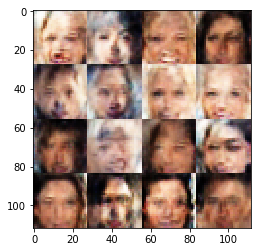

Epoch 0/1... Discriminator Loss: 0.9813... Generator Loss: 1.6176
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 1.2493
Epoch 0/1... Discriminator Loss: 1.1642... Generator Loss: 1.3808
Epoch 0/1... Discriminator Loss: 1.1927... Generator Loss: 1.0534
Epoch 0/1... Discriminator Loss: 0.9853... Generator Loss: 1.5881
Epoch 0/1... Discriminator Loss: 1.1588... Generator Loss: 1.3819
Epoch 0/1... Discriminator Loss: 1.1579... Generator Loss: 1.3198
Epoch 0/1... Discriminator Loss: 1.0462... Generator Loss: 1.4740
Epoch 0/1... Discriminator Loss: 0.9979... Generator Loss: 1.2115
Epoch 0/1... Discriminator Loss: 1.0645... Generator Loss: 1.6483


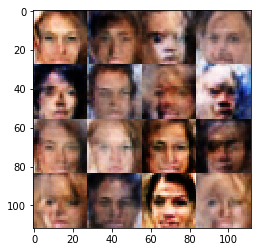

Epoch 0/1... Discriminator Loss: 1.2519... Generator Loss: 0.9038
Epoch 0/1... Discriminator Loss: 0.9423... Generator Loss: 1.4240
Epoch 0/1... Discriminator Loss: 1.1446... Generator Loss: 1.2642
Epoch 0/1... Discriminator Loss: 0.9180... Generator Loss: 1.4060
Epoch 0/1... Discriminator Loss: 1.0333... Generator Loss: 1.4392
Epoch 0/1... Discriminator Loss: 1.0562... Generator Loss: 0.9640
Epoch 0/1... Discriminator Loss: 1.1240... Generator Loss: 0.9302
Epoch 0/1... Discriminator Loss: 1.1308... Generator Loss: 1.7632
Epoch 0/1... Discriminator Loss: 1.0484... Generator Loss: 1.2010
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 1.0942


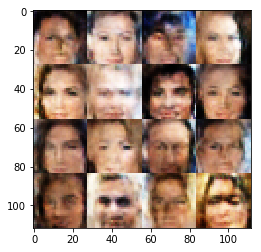

Epoch 0/1... Discriminator Loss: 1.1168... Generator Loss: 0.9692
Epoch 0/1... Discriminator Loss: 1.1843... Generator Loss: 0.9641
Epoch 0/1... Discriminator Loss: 0.9310... Generator Loss: 1.4790
Epoch 0/1... Discriminator Loss: 1.0431... Generator Loss: 1.4341
Epoch 0/1... Discriminator Loss: 1.1448... Generator Loss: 1.1511
Epoch 0/1... Discriminator Loss: 1.0464... Generator Loss: 1.1764
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 1.3085
Epoch 0/1... Discriminator Loss: 1.3512... Generator Loss: 0.9761
Epoch 0/1... Discriminator Loss: 0.9647... Generator Loss: 1.3168
Epoch 0/1... Discriminator Loss: 0.9740... Generator Loss: 1.7732


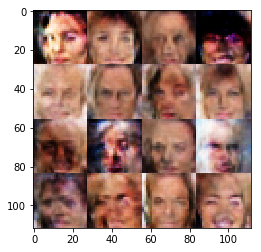

Epoch 0/1... Discriminator Loss: 1.1142... Generator Loss: 1.5740
Epoch 0/1... Discriminator Loss: 1.0845... Generator Loss: 1.4287
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 1.5306
Epoch 0/1... Discriminator Loss: 0.9423... Generator Loss: 1.2263
Epoch 0/1... Discriminator Loss: 1.1516... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 1.0915... Generator Loss: 1.0397
Epoch 0/1... Discriminator Loss: 0.9650... Generator Loss: 1.6026
Epoch 0/1... Discriminator Loss: 1.0775... Generator Loss: 0.8070
Epoch 0/1... Discriminator Loss: 1.3700... Generator Loss: 1.2232
Epoch 0/1... Discriminator Loss: 1.1521... Generator Loss: 1.4441


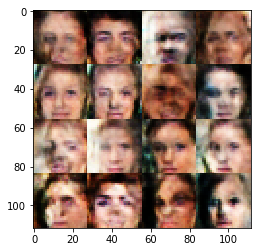

Epoch 0/1... Discriminator Loss: 1.0606... Generator Loss: 1.9888
Epoch 0/1... Discriminator Loss: 1.1447... Generator Loss: 1.5164
Epoch 0/1... Discriminator Loss: 1.0179... Generator Loss: 1.3844
Epoch 0/1... Discriminator Loss: 1.1605... Generator Loss: 1.0878
Epoch 0/1... Discriminator Loss: 1.0693... Generator Loss: 0.9955
Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 1.3228
Epoch 0/1... Discriminator Loss: 0.8660... Generator Loss: 1.5444
Epoch 0/1... Discriminator Loss: 1.2878... Generator Loss: 0.7361
Epoch 0/1... Discriminator Loss: 0.9871... Generator Loss: 1.5131
Epoch 0/1... Discriminator Loss: 1.0013... Generator Loss: 1.1773


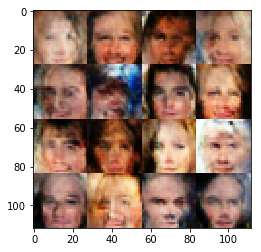

Epoch 0/1... Discriminator Loss: 0.9916... Generator Loss: 1.2422
Epoch 0/1... Discriminator Loss: 0.9744... Generator Loss: 1.2253
Epoch 0/1... Discriminator Loss: 1.2628... Generator Loss: 1.6945
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 1.3935
Epoch 0/1... Discriminator Loss: 0.9807... Generator Loss: 1.6769
Epoch 0/1... Discriminator Loss: 1.0926... Generator Loss: 1.5865
Epoch 0/1... Discriminator Loss: 1.1135... Generator Loss: 0.8712
Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 1.1100
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 1.2649
Epoch 0/1... Discriminator Loss: 1.0941... Generator Loss: 1.5120


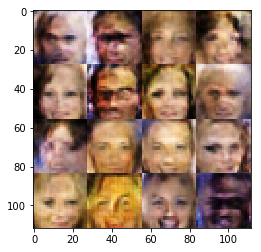

Epoch 0/1... Discriminator Loss: 0.9797... Generator Loss: 1.1135
Epoch 0/1... Discriminator Loss: 1.2740... Generator Loss: 2.0298
Epoch 0/1... Discriminator Loss: 1.0934... Generator Loss: 1.2674
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 1.0102
Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 1.3685
Epoch 0/1... Discriminator Loss: 1.0639... Generator Loss: 1.5188
Epoch 0/1... Discriminator Loss: 1.2263... Generator Loss: 1.0938
Epoch 0/1... Discriminator Loss: 1.1108... Generator Loss: 1.5565
Epoch 0/1... Discriminator Loss: 1.2330... Generator Loss: 1.4332
Epoch 0/1... Discriminator Loss: 1.0995... Generator Loss: 0.8736


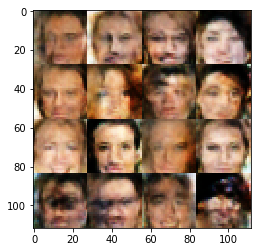

Epoch 0/1... Discriminator Loss: 1.1918... Generator Loss: 1.1961
Epoch 0/1... Discriminator Loss: 1.2514... Generator Loss: 0.9618
Epoch 0/1... Discriminator Loss: 0.9033... Generator Loss: 1.2975
Epoch 0/1... Discriminator Loss: 1.1370... Generator Loss: 1.0306
Epoch 0/1... Discriminator Loss: 1.1563... Generator Loss: 1.7282
Epoch 0/1... Discriminator Loss: 1.1002... Generator Loss: 1.2037
Epoch 0/1... Discriminator Loss: 0.9604... Generator Loss: 1.4971


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.